In [164]:
# imports
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import pprint
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import re
from os import path, getcwd
from PIL import Image

In [120]:
df = pd.read_csv('lyrics.csv')
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [121]:
#replace carriage returns
df = df.replace({'\n': ' '}, regex=True)
df.head()

,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing? You know I'm gonna cut..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy, it's like you seem..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search For tenderness It isn't hard to ...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I [Verse 1:] If I wrote a..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


In [122]:
# remove nans
df = df.dropna()

# remove ones that aren't in set
#df = df[df.genre != 'Rock']
#df = df[df.genre != 'Pop']
#df = df[df.genre != 'Hip-Hop']
df = df[df.genre != 'Not Available']

In [123]:
# shuffle data
random.seed(10)
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,index,song,year,artist,genre,lyrics
0,359114,take-me-away,2006,christina-vidal,Rock,"Get up, get out Move 'em, move 'em, there's no..."
1,26037,good-times,1979,chic,Electronic,"Good times, these are the good times Leave you..."
2,325599,somniferum,2006,babylon-whores,Rock,Down on the street The night is a whore for dr...
3,213970,gold-into-straw,2006,brendan-benson,Pop,I'm writing the words to this song with a pois...
4,202650,hate-me,2006,blue-october,Rock,I have to block out thoughts of you so I don't...


In [177]:
# get lyrics
genres, lyrics = [], []
for x1, x2 in zip(df['lyrics'], df['genre']):
    genres.append(x2.lower())
    lyrics.append(x1)

In [178]:
print(len(genres))
print(len(lyrics))

242615
242615


In [125]:
# get number of total genres
total_genres = len(set(genres))
print("Num genres: %d" % (total_genres))

# create training and test set
training_x = lyrics[:len(lyrics)//2]
training_y = genres[:len(lyrics)//2]

test_x = lyrics[len(lyrics)//2:]
test_y = genres[len(lyrics)//2:]

Num genres: 11


____________________________________________________________________
## SVM balanced classifier, using unigrams (words)

In [213]:
# svm classifier with words
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=1, class_weight='auto')))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/ana

Accuracy: 0.491155


In [214]:
# performance by genre
correct_by_genre = defaultdict(int)
incorrect_by_genre = defaultdict(int)
pct_correct_by_genre = defaultdict(float)
for label, prediction in zip(test_y, predictions):
    if (label == prediction):
        correct_by_genre[label] += 1
    else:
        incorrect_by_genre[label] += 1
for genre in correct_by_genre:
    pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
svm_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)

____________________________________________________________________
## Logistic Regression balanced classifier, using unigrams (words)

In [216]:
# logistic regressor
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LogisticRegression(class_weight='auto')))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/anaconda/lib/python3.6/site-packages/sklearn/utils/class_weight.py:65: DeprecationWarning:

The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19

/Users/hubes/ana

Accuracy: 0.479696


In [11]:
# performance by genre
correct_by_genre = defaultdict(int)
incorrect_by_genre = defaultdict(int)
pct_correct_by_genre = defaultdict(float)
for label, prediction in zip(test_y, predictions):
    if (label == prediction):
        correct_by_genre[label] += 1
    else:
        incorrect_by_genre[label] += 1
for genre in correct_by_genre:
    pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
log_regression_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)

In [219]:
# Top-N accuracy
predict_probs = classifier.predict_proba(test_x)
n = 4
top_ns = []
for pp in predict_probs:
    prob_cat = zip(pp, classifier.classes_)
    top_ns.append([cat for prob, cat in sorted(prob_cat)[-n:]])
    
top_n_correct = 0
for label, top_n in zip(test_y, top_ns):
    if label in top_n:
        top_n_correct += 1
print("Top-%d Accuracy: %f" % (n, float(top_n_correct)/float(len(test_y))))

Top-4 Accuracy: 0.805297


____________________________________________________________________
## SVM unbalanced classifier, using unigrams (words)

In [12]:
# svm classifier without class balance
classifier = Pipeline([
    ('vectorizer', CountVectorizer(stop_words='english', analyzer='word')),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC(C=1)))])
classifier.fit(training_x, training_y)
predictions = classifier.predict(test_x)
# get accuracy
correct = 0
for label, prediction in zip(test_y, predictions):
    if label == prediction:
        correct += 1
print("Accuracy: %f" % (float(correct)/float(len(test_y))))

Accuracy: 0.596144


In [13]:
# performance by genre
correct_by_genre = defaultdict(int)
incorrect_by_genre = defaultdict(int)
pct_correct_by_genre = defaultdict(float)
for label, prediction in zip(test_y, predictions):
    if (label == prediction):
        correct_by_genre[label] += 1
    else:
        incorrect_by_genre[label] += 1
for genre in correct_by_genre:
    pct_correct_by_genre[genre] = correct_by_genre[genre] / (correct_by_genre[genre]+incorrect_by_genre[genre])
svm_no_balance_stats = sorted(pct_correct_by_genre.items(), key=lambda x:x[1], reverse=True)

________________________________________________________________________________
## Data visualization

In [105]:
# this is my api key pls delete later
plotly.tools.set_credentials_file(username='hle000', api_key='uY8PP35cvY4kj5itzZKY')

In [127]:
"""
Get average words per song per genre.
"""
plotted_genres = ['hip-hop', 'metal', 'country', 'rock', 'jazz', 'pop', 'electronic', 'folk', 'other', 'r&b', 'indie']
num_words_by_genre = defaultdict(int)

# get number of words per average
num_words = [len(row.split(" ")) for row in lyrics]
for word_count, genre in zip(num_words, genres):
    num_words_by_genre[genre] += word_count
    
# get number of songs per genre
songs_per_genre = defaultdict(int)
for genre in genres:
    songs_per_genre[genre] += 1
    
# get average words per genre
avg_words_per_genre = {}
for genre in plotted_genres:
    avg_words_per_genre[genre] = num_words_by_genre[genre] / songs_per_genre[genre]
pprint.pprint(avg_words_per_genre)

# get words per genre
words_per_song_by_genre = defaultdict(list)
for word_count, genre in zip(num_words, genres):
    if word_count > 1000:
        continue
    words_per_song_by_genre[genre].append(word_count)

{'country': 186.08389518315147,
 'electronic': 193.35952799397438,
 'folk': 181.01471243869818,
 'hip-hop': 489.93360160965796,
 'indie': 196.85138139091777,
 'jazz': 172.06361355081555,
 'metal': 169.05496864346142,
 'other': 223.89169396800926,
 'pop': 245.64797607868334,
 'r&b': 224.9376653925316,
 'rock': 190.6831418501396}


In [142]:
"""
Plot songs per genre.
"""
# songs_per_genre
count_to_genre = {}
for key,item in songs_per_genre.items():
    count_to_genre[item] = key
counts = [x for x in count_to_genre]
counts.sort()
data = [go.Bar(
            x=counts,
            y=[count_to_genre[x] for x in counts],
            orientation = 'h', 
            marker=dict(
        color='rgb(150, 9, 200)'
    )
)]

py.iplot(data, filename='horizontal-bar')

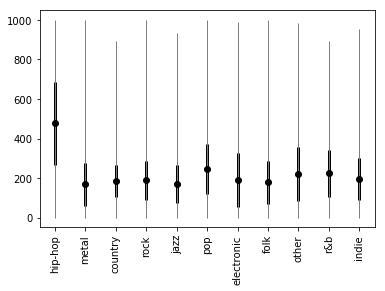

In [134]:
"""
Plot words in a song per genre.
"""
    
mins = []
maxes = []
means = []
std = []
for genre in plotted_genres:
    words_list = words_per_song_by_genre[genre]
    mins.append(min(words_list))
    maxes.append(max(words_list))
    mean = sum(words_list)/len(words_list)
    means.append(mean)
    std.append(np.std(words_list))
mins = np.array(mins)
maxes = np.array(maxes)
means = np.array(means)
std = np.array(std)

# create stacked errorbars:
plt.errorbar(np.arange(11), means, std, fmt='ok', lw=3)
plt.errorbar(np.arange(11), means, [means - mins, maxes - means],
            f fmt='.k', ecolor='gray', lw=1)
plt.xticks([x for x in range(11)], plotted_genres, rotation='vertical')

plt.show()

In [212]:
"""
Get the top 3 most popular words, per genre.
"""
# set some custom stopwords
stopwords = set(STOPWORDS)
stopwords.add('im')
stopwords.add('dont')
stopwords.add('know')
stopwords.add('got')
stopwords.add('now')
stopwords.add('oh')

most_popular = defaultdict(dict)
for genre, lyric in zip(genres, lyrics):
    text = lyric.lower()
    # remove punctuation
    text = text.replace('(', '')
    text = text.replace(')', '')
    text = text.replace('-', '')
    text = text.replace('\'', '')
    text = text.replace('!', '')
    text = text.replace('?', '')
    text = text.replace('  ', ' ')
    text = text.replace(',', '')
    
    # break into spaces
    tokens = text.split(' ')
    
    # remove stopwords
    tokens = [x for x in tokens if x not in stopwords]
    for token in tokens:
        if token not in most_popular[genre]:
            most_popular[genre][token] = 0
        most_popular[genre][token] += 1

# print 5 most popular words
for genre in ['rock', 'metal', 'hip-hop', 'pop']:
    tmp = sorted(most_popular[genre], key=most_popular[genre].get, reverse=True)[:5]
    res = []
    for word in tmp:
        res.append((most_popular[genre][word], word))
    print("Genre: %s" % (genre))
    pprint.pprint(res)
    print()

Genre: rock
[(100740, 'love'),
 (76125, 'youre'),
 (71748, 'time'),
 (67795, 'never'),
 (66983, 'will')]

Genre: metal
[(22736, 'will'),
 (13366, 'life'),
 (12794, 'one'),
 (12695, 'time'),
 (12250, 'see')]

Genre: hip-hop
[(47243, 'aint'),
 (42068, 'nigga'),
 (39207, 'cause'),
 (35927, 'shit'),
 (34274, 'go')]

Genre: pop
[(81892, 'love'),
 (39699, 'youre'),
 (39311, 'baby'),
 (34125, 'go'),
 (33405, 'want')]



2500 lyrics finished..
5000 lyrics finished..
7500 lyrics finished..
10000 lyrics finished..
12500 lyrics finished..
15000 lyrics finished..
17500 lyrics finished..
20000 lyrics finished..
22500 lyrics finished..
25000 lyrics finished..
27500 lyrics finished..
30000 lyrics finished..
32500 lyrics finished..
35000 lyrics finished..
37500 lyrics finished..
40000 lyrics finished..
42500 lyrics finished..
45000 lyrics finished..
47500 lyrics finished..
50000 lyrics finished..
52500 lyrics finished..
55000 lyrics finished..
57500 lyrics finished..
60000 lyrics finished..
62500 lyrics finished..
65000 lyrics finished..
67500 lyrics finished..
70000 lyrics finished..
72500 lyrics finished..
75000 lyrics finished..
77500 lyrics finished..
80000 lyrics finished..
82500 lyrics finished..
85000 lyrics finished..
87500 lyrics finished..
90000 lyrics finished..
92500 lyrics finished..
95000 lyrics finished..
97500 lyrics finished..
100000 lyrics finished..
102500 lyrics finished..
105000 lyrics fin

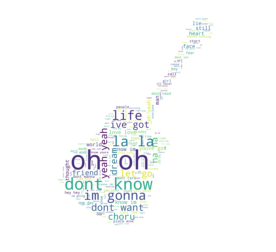

In [210]:
"""
Plot word cloud.
"""
# CHANGE THIS VAR TO MATCH THE CLOUD U WANT
target_genre = "rock"
text = ""
i = 0
for song_lyrics, genre in zip(lyrics, genres):
    if genre == target_genre:
        # lower case only
        song_lyrics = song_lyrics.lower()
        text += " " + song_lyrics 
        i += 1
        if i % 2500 == 0:
            print("%d lyrics finished.." % (i))
print(i)
            
print("Text preprocessing done.")

# remove punctuation
text = text.replace('(', '')
text = text.replace(')', '')
text = text.replace('\'', '')
text = text.replace('!', '')
text = text.replace('  ', ' ')

# remove stopwords
stopwords = set(STOPWORDS)
stopwords.add("said")

# make shape
base = getcwd()
guitar_mask = np.array(Image.open(path.join(base, "guitar.jpeg")))

wordcloud = WordCloud(width=3000, height=3000, scale=5, max_font_size=120, background_color="white", stopwords=stopwords, mask=guitar_mask).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# save to file
wordcloud.to_file(path.join(base, target_genre + ".png"))

In [61]:
"""
Plot balanced SVM vs balanced Logistic regressor.
"""

trace1 = go.Bar(
    x=plotted_genres,
    y=[ele[1] for ele in svm_stats],
    name='SVM'
)
trace2 = go.Bar(
    x=plotted_genres,
    y=[ele[1] for ele in log_regression_stats],
    name='Log Regresion'
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Accuracy by Genre",
    barmode='group', 
    yaxis=dict(
        autotick=False,
        ticks='outside',
        tick0=0,
        dtick=0.1,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hle000/0 or inside your plot.ly account where it is named 'grouped-bar'


In [62]:
"""
Plot balanced SVM vs unbalanced SVM.
"""
trace1 = go.Bar(
    x=plotted_genres,
    y=[x[1] for x in svm_stats],
    name='SVM-Balanced'
)
trace2 = go.Bar(
    x=plotted_genres,
    y=[x[1] for x in svm_no_balance_stats],
    name='SVM-Unalanced', 
    marker=dict(
        color='rgb(235, 40, 40)'
    )
)

data = [trace1, trace2]
layout = go.Layout(
    title = "Accuracy by Genre",
    barmode='group', 
    yaxis=dict(
        autotick=False,
        ticks='outside',
        tick0=0,
        dtick=0.1,
        ticklen=8,
        tickwidth=4,
        tickcolor='#000'
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~hle000/0 or inside your plot.ly account where it is named 'grouped-bar'
